In [1]:
import os
import numpy as np
import pandas as pd
import cooler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from umap import UMAP
import pickle
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score

/share/home/mliu/anaconda3/envs/impute/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-10 01:15:14.322317: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-10 01:15:15.750815: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 01:15:27.528071: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
def plot_matrix(mat,title,cmap,vmin,vmax,show):
    plt.figure(figsize=(4,4))
    plt.imshow(mat,interpolation='nearest',cmap=cmap,vmin=vmin,vmax=vmax)
    if show:
        plt.colorbar()
    plt.title(title)
    #不显示刻度
    plt.xticks([])
    plt.yticks([])
    plt.show()
def plot_embedding(matrix,cell_type,color_dict,title):
    plt.figure(figsize=(4,4))
    sns.scatterplot(x=matrix[:, 0], y=matrix[:, 1], hue=cell_type, s=6, linewidth=0, palette=color_dict)
    #不显示上边框和右边框
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.title(title)
    
color_dict = {
    'GM12878': '#66c2a5',
    'HeLa': '#fc8d62',
    'HAP1': '#8da0cb',
    'K562': '#e78ac3',
}
color_dict_cluster = {
    0:"#e41a1c",
    1:"#377eb8",
    2:"#4daf4a",
    3:"#984ea3",
}
chr_list = ["chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10","chr11","chr12","chr13","chr14","chr15","chr16","chr17","chr18","chr19","chr20","chr21","chr22"]
label_info_path = "/shareb/mliu/evaluate_impute/tools/Higashi/Higashi/tutorials/dataset/Ramani/label_info.pickle"
with open(label_info_path, 'rb') as f:
    cell_type = pickle.load(f)['cell type']

## 0-raw

In [3]:
raw_dir = '/share/home/mliu/shareb/mliu/evaluate_impute/data/real_sc_hic/Ramani/cooler'

In [4]:
vector_list = []
for chr in chr_list:
    chr_vector_list = []
    for c in range(0,620):
        filepath = f"{raw_dir}/cell{c}.cool"
        clr = cooler.Cooler(filepath)
        matrix_chr = clr.matrix(balance=False).fetch(chr)
        #matrix to vector
        chr_vector = matrix_chr.flatten()
        chr_vector_list.append(chr_vector)
    chr_array = np.array(chr_vector_list)
    vec1 = PCA(n_components=40).fit_transform(chr_array)
    vector_list.append(vec1)
concatenated_matrix = np.concatenate(vector_list, axis=1)

In [5]:
vec_pca = PCA(n_components=10).fit_transform(concatenated_matrix)
vec_pca_vis_raw = PCA(n_components=2).fit_transform(vec_pca)
vec_umap_raw = UMAP(n_components=2).fit_transform(vec_pca)
vec_tsne_raw = TSNE(n_components=2).fit_transform(vec_pca)
plot_embedding(vec_umap_raw,cell_type,color_dict,"Raw")

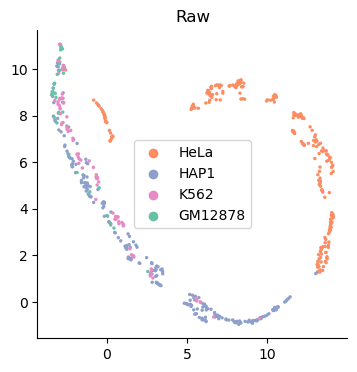

In [121]:
#用kmeans聚类
kmeans_raw = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(vec_pca)

In [123]:
kmeans_raw = KMeans(n_clusters=4, random_state=0).fit(vec_pca)
predicted_labels_raw = kmeans_raw.labels_
ari_score = adjusted_rand_score(cell_type, predicted_labels_raw)

/share/home/mliu/anaconda3/envs/impute/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


-0.005994043401334662


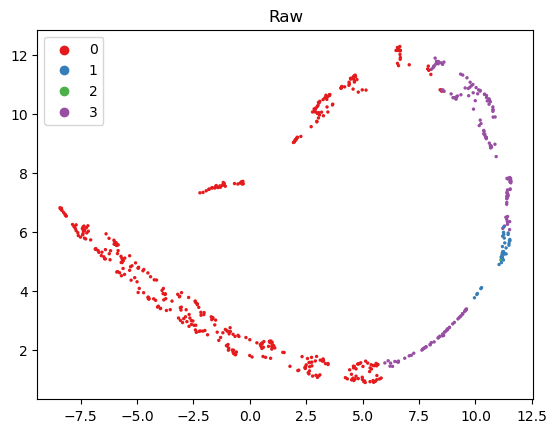

In [124]:
plot_embedding(vec_umap_raw,predicted_labels_raw,color_dict_cluster,"Raw")
print(ari_score)

## 1-hicrep

In [7]:
vector_list = []
for chr in chr_list:
    print(chr)
    matrix_path = f"/shareb/mliu/evaluate_impute/data/imputed_data/hicrep/hicrep_imputed_Ramani_{chr}.npy"
    matrix = np.load(matrix_path)
    matrix_flatten = matrix.reshape(matrix.shape[0], -1)
    vector_list.append(PCA(n_components=40).fit_transform(matrix_flatten))
concatenated_matrix_hicrep = np.concatenate(vector_list, axis=1)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22


In [8]:
vec_pca_hicrep = PCA(n_components=10).fit_transform(concatenated_matrix_hicrep)
vec_pca_vis_hicrep = PCA(n_components=2).fit_transform(vec_pca_hicrep)
vec_umap_hicrep = UMAP(n_components=2).fit_transform(vec_pca_hicrep)
vec_tsne_hicrep = TSNE(n_components=2).fit_transform(vec_pca_hicrep)
plot_embedding(vec_umap_hicrep,cell_type,color_dict,"HicRep")

## 2-scl

## 3-snapHi-C

## 4-genomDISCO

In [10]:
vector_list = []
for chr in chr_list:
    print(chr)
    matrix_path = f"/shareb/mliu/evaluate_impute/data/imputed_data/genomdisco/genomdisco_imputed_Ramani_{chr}.npy"
    matrix = np.load(matrix_path)
    matrix_flatten = matrix.reshape(matrix.shape[0], -1)
    vector_list.append(PCA(n_components=40).fit_transform(matrix_flatten))
concatenated_matrix_disco = np.concatenate(vector_list, axis=1)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22


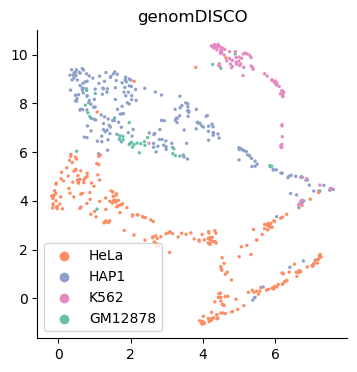

In [11]:
vec_pca_disco = PCA(n_components=10).fit_transform(concatenated_matrix_disco)
vec_pca_vis_disco = PCA(n_components=2).fit_transform(vec_pca_disco)
vec_umap_disco = UMAP(n_components=2).fit_transform(vec_pca_disco)
vec_tsne_disco = TSNE(n_components=2).fit_transform(vec_pca_disco)
plot_embedding(vec_umap_disco,cell_type,color_dict,"genomDISCO")

## 5-ctg

In [13]:
vector_list = []
for chr in chr_list:
    print(chr)
    matrix_path = f"/shareb/mliu/evaluate_impute/data/imputed_data/ctg/ctg_imputed_Ramani_{chr}.npy"
    matrix = np.load(matrix_path)
    matrix_flatten = matrix.reshape(matrix.shape[0], -1)
    vector_list.append(PCA(n_components=40).fit_transform(matrix_flatten))
concatenated_matrix_ctg = np.concatenate(vector_list, axis=1)

chr1


chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22


In [ ]:
vec_pca_ctg = PCA(n_components=10).fit_transform(concatenated_matrix_ctg)
vec_pca_vis_ctg = PCA(n_components=2).fit_transform(vec_pca_ctg)
vec_umap_ctg = UMAP(n_components=2).fit_transform(vec_pca_ctg)
vec_tsne_ctg = TSNE(n_components=2).fit_transform(vec_pca_ctg)
plot_embedding(vec_umap_ctg,cell_type,color_dict,"genomDISCO")

## 6-schicluster

In [63]:
vector_list = []
for chr in chr_list:
    print(chr)
    matrix_path = f"/shareb/mliu/evaluate_impute/data/imputed_data/schicluster/schicluster_imputed_Ramani_{chr}.npy"
    matrix = np.load(matrix_path)
    matrix_flatten = matrix.reshape(matrix.shape[0], -1)
    vector_list.append(PCA(n_components=40).fit_transform(matrix_flatten))
concatenated_matrix_schicluster = np.concatenate(vector_list, axis=1)

chr1
(620, 62500)
chr2
(620, 59536)
chr3
(620, 39601)
chr4
(620, 36864)
chr5
(620, 32761)
chr6
(620, 29584)
chr7
(620, 25600)
chr8
(620, 21609)
chr9
(620, 20164)
chr10
(620, 18496)
chr11
(620, 18496)
chr12
(620, 17956)
chr13
(620, 13456)
chr14
(620, 11664)
chr15
(620, 10609)
chr16
(620, 8281)
chr17
(620, 6724)
chr18
(620, 6241)
chr19
(620, 3600)
chr20
(620, 4096)
chr21
(620, 2401)
chr22
(620, 2704)


In [127]:
vec_pca_schiluster = PCA(n_components=10).fit_transform(concatenated_matrix_schicluster)
vec_pca_vis_schiluster = PCA(n_components=2).fit_transform(vec_pca_schiluster)
vec_umap_schiluster = UMAP(n_components=2).fit_transform(vec_pca_schiluster)
vec_tsne_schiluster = TSNE(n_components=2).fit_transform(vec_pca_schiluster)

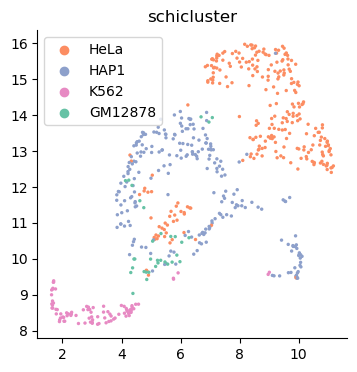

In [131]:
plot_embedding(vec_umap_schiluster,cell_type,color_dict,"schicluster")

/share/home/mliu/anaconda3/envs/impute/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.13082410350742377


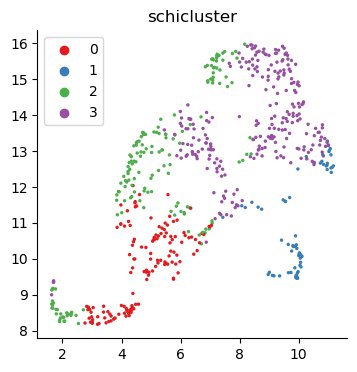

In [135]:
kmeans_raw = KMeans(n_clusters=4, random_state=0,init='k-means++').fit(vec_pca_schiluster)
predicted_labels = kmeans_raw.labels_
ari_score = adjusted_rand_score(cell_type, predicted_labels)
plot_embedding(vec_umap_schiluster,predicted_labels,color_dict_cluster,"schicluster")
print(ari_score)

## 7-higashi

In [ ]:
vector_list = []
for chr in chr_list:
    print(chr)
    matrix_path = f"/shareb/mliu/evaluate_impute/data/imputed_data/higashi/higashi_imputed_Ramani_{chr}.npy"
    matrix = np.load(matrix_path)
    matrix_flatten = matrix.reshape(matrix.shape[0], -1)
    vector_list.append(PCA(n_components=40).fit_transform(matrix_flatten))
concatenated_matrix_ctg = np.concatenate(vector_list, axis=1)